### **Introduction**

This notebook implements **Multiple Linear Regression** using the **Gradient Descent** optimization algorithm, with a strong emphasis on **vectorization** for computational efficiency and performance improvement.

In this implementation:
- **Gradient Descent** is used to iteratively minimize the cost function, adjusting the model's parameters to achieve the best-fit line.
- **Vectorization** is applied throughout the entire process, including:
  - **Gradient Calculation**: We vectorize the gradient descent update rule to perform all operations in parallel, avoiding the need for costly for-loops.
  - **Cost Function**: The cost function \( J(\theta) \) is computed using matrix operations to eliminate loops and improve the speed of computation, particularly when handling large datasets.
  - **Feature Scaling**: To enhance the performance of gradient descent, features are scaled using vectorized operations, ensuring that all input variables are normalized before training.
  
The model is trained on a dataset (e.g., **Auto MPG dataset**) to predict a continuous target variable based on multiple features.

Key concepts covered:
- **Gradient Descent**: The optimization algorithm used to minimize the cost function.
- **Cost Function**: A measure of how well the model's predictions match the actual values, minimized during the training process.
- **Vectorization**: Leveraging matrix and vector operations to compute gradients, cost, and other necessary transformations efficiently, reducing computational complexity.
- **Feature Scaling**: Normalizing input features to ensure that gradient descent converges more quickly.

This approach not only demonstrates how to implement linear regression efficiently but also highlights the power of vectorization in scaling machine learning models to large datasets.


### **Development**

1. [Import Libraries](01_LR_using_GD_and_vectorization.ipynb#import-libraries)
2. [Get Data](01_LR_using_GD_and_vectorization.ipynb#get-data)
3. [Feature Scaling](01_LR_using_GD_and_vectorization.ipynb#feature-scaling)
4. [Linear Regression Model: Theoretical definition](01_LR_using_GD_and_vectorization.ipynb#linear-regression-model-theoretical-definition)
5. [Linear Regression Model: Implementation](01_LR_using_GD_and_vectorization.ipynb#linear-regression-model-implementation)
6. [Implement Gradient Descent](01_LR_using_GD_and_vectorization.ipynb#implement-gradient-descent)
7. [Predictions Over Data Test](01_LR_using_GD_and_vectorization.ipynb#predictions-over-data-test)
8. [Conclusion](01_LR_using_GD_and_vectorization.ipynb#conclusion)

#### **Import Libraries**

In [60]:
# Import Libraries
import copy
import math
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
import pandas as pd

#### **Get Data**

The Auto MPG dataset is a collection of data used for predicting a vehicle's miles per gallon (MPG) based on various features. It contains the following columns:

- mpg: Miles per gallon (target variable).
- cylinders: Number of cylinders in the engine.
- displacement: Engine displacement in cubic inches.
- horsepower: Engine horsepower.
- weight: Vehicle weight in pounds.
- acceleration: Acceleration in meters per second squared.
- model_year: Model year of the car.
- origin: Country of origin (1 = USA, 2 = Europe, 3 = Japan).
- car_name: Car name.

It is commonly used for regression tasks to predict fuel efficiency based on these features.

In [4]:
# Load Dataset
auto_mpg = fetch_ucirepo(id=9)

# Create DataFrame
df_auto_mpg = auto_mpg['data']['original']

# Preview Data
df_auto_mpg.head(4)

,car_name,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
0,"chevrolet,chevelle,malibu",8,307.0,130.0,3504,12.0,70,1,18.0
1,"buick,skylark,320",8,350.0,165.0,3693,11.5,70,1,15.0
2,"plymouth,satellite",8,318.0,150.0,3436,11.0,70,1,18.0
3,"amc,rebel,sst",8,304.0,150.0,3433,12.0,70,1,16.0


In [5]:
# Review Missing Values
df_auto_mpg.isna().sum()

car_name        0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
mpg             0
dtype: int64

In [6]:
# Drop Missing Values
df_auto_mpg.dropna(inplace=True)

print(f'Size Df: {df_auto_mpg.shape=}\n')
print(df_auto_mpg.isna().sum())

Size Df: df_auto_mpg.shape=(392, 9)

car_name        0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
mpg             0
dtype: int64


##### **Visualization Analysis**

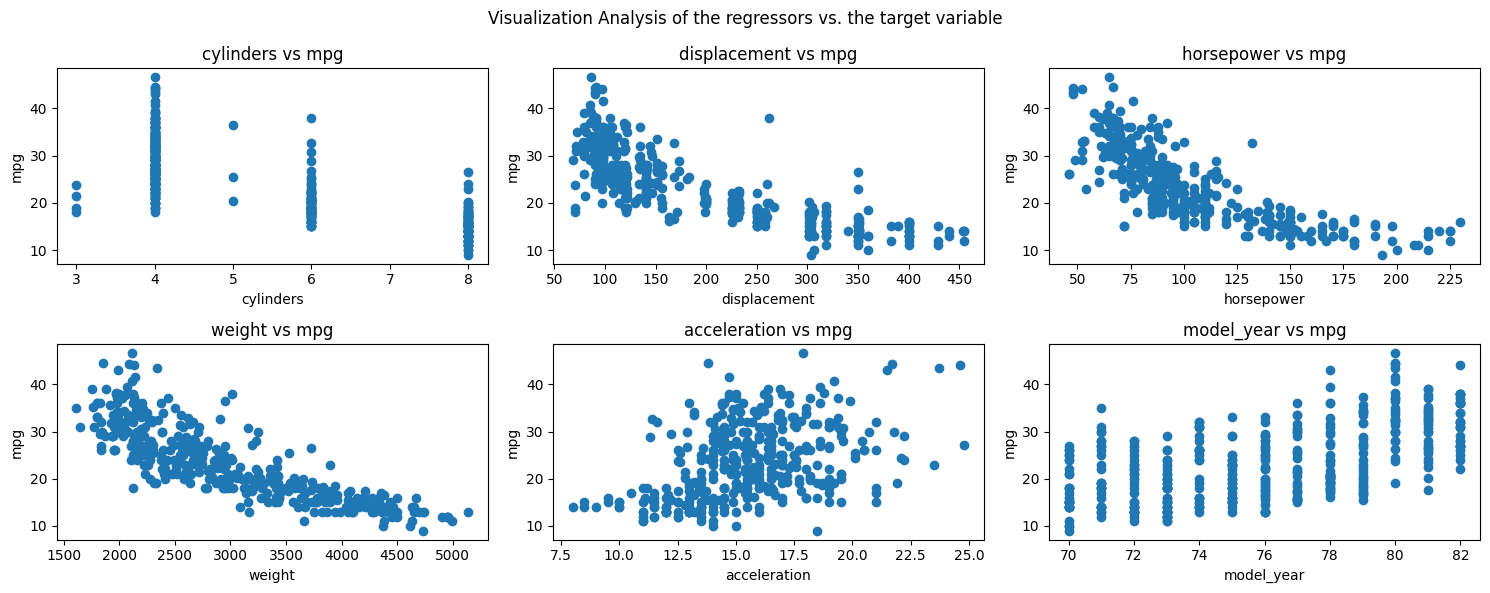

In [7]:
# Define variables to plot
variables = df_auto_mpg.drop(columns=['car_name', 'mpg', 'origin']).columns
target_variable = 'mpg'

# Number of columns per row (3 subplots per row)
n_cols = 3

# Define Rows Number
n_rows = (len(variables) + n_cols - 1) // n_cols

# Create subplots: n_rows rows and n_cols columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))

# Flatten the axes array to facilitate iteration
axes = axes.flatten()

# Plot each variable in relation to 'MPG'.
for i, var in enumerate(variables):
    axes[i].scatter(df_auto_mpg[var], df_auto_mpg[target_variable])
    axes[i].set_title(f'{var} vs {target_variable}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel(target_variable)

# Hide empty subplots if any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust the subplots
plt.suptitle('Visualization Analysis of the regressors vs. the target variable')
plt.tight_layout()
plt.show()

##### **Split Data: Training and Test Datasets**

In [96]:
# Split Dataset: Train-Test
shuffled_data = df_auto_mpg.sample(frac=1, random_state=123).reset_index(drop=True)

# Define Split
train_size = 0.8  # 80% train
test_size = 1 - train_size  # 20% test

# Calculate the division index
train_index = int(len(shuffled_data) * train_size)

# Define Train and Test Dataset
train_data = shuffled_data[:train_index]
test_data = shuffled_data[train_index:]

print(f'Train Data: {train_data.shape=}')
print(f'Test Data: {test_data.shape=}')

Train Data: train_data.shape=(313, 9)
Test Data: test_data.shape=(79, 9)


In [29]:
# Define X & y: Train
x_train = train_data.drop(columns=['car_name', 'mpg', 'origin']).values # Use numpy arrays
y_train = train_data['mpg'].values

print(f'x Train: {x_train.shape=}')
print(f'y Train: {y_train.shape=}')

# Define X & y: Test
x_test = test_data.drop(columns=['car_name', 'mpg', 'origin']).values # Use numpy arrays
y_test = test_data['mpg'].values

print(f'x Test: {x_test.shape=}')
print(f'y Test: {y_test.shape=}')

x Train: x_train.shape=(313, 6)
y Train: y_train.shape=(313,)
x Test: x_test.shape=(79, 6)
y Test: y_test.shape=(79,)


#### **Feature Scaling**

##### **Theoretical Definition**

- Let's use z-score normalization.

After z-score normalization, all features will have a mean of 0 and a standard deviation of 1.

To implement z-score normalization, adjust your input values as shown in this formula:
$$x^{(i)}_j = \dfrac{x^{(i)}_j - \mu_j}{\sigma_j} \tag{1}$$ 
where $j$ selects a feature or a column in the $\mathbf{X}$ matrix. $µ_j$ is the mean of all the values for feature (j) and $\sigma_j$ is the standard deviation of feature (j).
$$
\begin{align}
\mu_j &= \frac{1}{m} \sum_{i=0}^{m-1} x^{(i)}_j \tag{2}\\
\sigma^2_j &= \frac{1}{m} \sum_{i=0}^{m-1} (x^{(i)}_j - \mu_j)^2  \tag{3}
\end{align}
$$

>**Implementation Note:** When normalizing the features, it is important
to store the values used for normalization - the mean value and the standard deviation used for the computations. After learning the parameters
from the model, we often want to predict new data we have not
seen before. Given a new x value, we must first normalize x using the mean and standard deviation
that we had previously computed from the training set.

##### **Implementation**

In [30]:
def zscore_normalization(X):
    """Feature Scaling Process using z-score normalization"""
    # Compute mu
    mu = np.mean(X, axis=0) # for each variable in X -- mu will have shape (n,)

    # Compute std (Standard Deviation)
    sigma = np.std(X, axis=0) # for each variable in X -- sigma will have shape (n,)

    # Normalize X
    X_norm = (X - mu) / sigma

    return mu, sigma, X_norm

# Create Function to normalize new data
def zscore_normalization_new_data(new_X, mu, sigma):
    """Feature Scaling Process for new data using mu and sigma from X train"""
    # Normalize new data
    X_norm = (new_X - mu) / sigma

    return X_norm

In [31]:
# Normalize X_train
mu, sigma, x_train_norm = zscore_normalization(x_train)

#### **Linear Regression Model: Theoretical definition**

<a name="toc_15456_3"></a>
**1. Model Prediction With Multiple Variables**
- The model's prediction with multiple variables is given by the linear model:

$$ f_{\mathbf{w},b}(\mathbf{x}) =  w_0x_0 + w_1x_1 +... + w_{n-1}x_{n-1} + b \tag{1}$$
or in vector notation:
$$ f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b  \tag{2} $$ 
where $\cdot$ is a vector `dot product`

<a name="toc_15456_4"></a>
**2. The equation for the cost function with multiple variables** $J(\mathbf{w},b)$ is:
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 \tag{3}$$ 
where:
$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b  \tag{4} $$ 


$\mathbf{w}$ and $\mathbf{x}^{(i)}$ are vectors rather than scalars supporting multiple features.

<a name="toc_15456_5"></a>
**3. Gradient Descent With Multiple Variables:**

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{5}  \; & \text{for j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

where, n is the number of features, parameters $w_j$,  $b$, are updated simultaneously and where  

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{6}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{7}
\end{align}
$$
* m is the number of training examples in the data set

    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value

#### **Linear Regression Model: Implementation**

##### **Compute Cost Function J(w,b)**

In [32]:
def calculate_cost_function(X, y, w, b):
    """Calculate Cost Function using multiple variables"""
    assert type(w) == np.ndarray, f"w must be a numpy.ndarray! You passed an object type: {type(w)}"

    # Define number of traning examples
    m = X.shape[0]

    # Calculate predictions fw,b
    f_wb = np.dot(X, w) + b # Or instead: X @ w + b

    # Calculate Error: (fw,b - y)
    error_pred = (f_wb - y)**2

    # Calculate Total Cost: Summation on each example
    total_cost = (1 / (2*m)) * error_pred.sum()

    return total_cost

In [33]:
# Test Function Cost
w = np.array([0.01] * x_train.shape[1])
b = 2

total_cost_test = calculate_cost_function(x_train_norm, y_train, w, b)
print(f'Total Cost Test according to the array w and b values: {total_cost_test:.2f}')

Total Cost Test according to the array w and b values: 262.28


##### **Compute Gradient Descent**

In [97]:
def compute_gradient_descent(X, y, w, b):
    """Compute Gradient Descent using multiple variables"""
    assert type(w) == np.ndarray, f"w must be a numpy.ndarray! You passed an object type: {type(w)}"

    # Define number of traning examples and features
    m,_ = X.shape

    # Calculate partial derivative with respect to w: (fw,b - y) * x
    f_wb = X @ w + b # my estimated function
    e = f_wb - y # calculate errors
    dj_dw = (e @ X) / m # calculate derivative w

    # Calculate partial derivative with respcet to b: (fw,b - y)
    dj_db = e.sum() / m

    return dj_db, dj_dw

In [98]:
# Test Gradient Descent
dj_db, dj_dw = compute_gradient_descent(x_train_norm, y_train, w, b)

print(f'Derivative with respect to b: {dj_db:.4f}')
print(f'Derivative with respect to w: {dj_dw}')

Derivative with respect to b: -21.5022
Derivative with respect to w: [ 6.18467575  6.35439426  6.11708811  6.62365149 -3.32356589 -4.38576435]


In [99]:
# Compute Cost Function J
alpha = 0.001
w_new = w - alpha * dj_dw
b_new = b - alpha * dj_db

total_cost_test_gd = calculate_cost_function(x_train, y_train, w_new, b_new)
print(f'Total Cost Test according to the array w and b values: {total_cost_test_gd:.2f}')

Total Cost Test according to the array w and b values: 98.91


#### **Implement Gradient Descent**

In [37]:
def gradient_descent(X, y, w_init:np.ndarray, b_init:int, alpha:float, num_iters:int, print_intervarls:int) -> tuple:
    """Execute Gradient Descent over a specific number of iterations"""
    assert type(w_init) == np.ndarray, f"w must be a numpy.ndarray! You passed an object type: {type(w)}"

    # Set Variables
    cost_function_history = []
    b = copy.copy(b_init) # make copy
    w = copy.copy(w_init)

    # Iterate over num_iters parameter
    for i in range(num_iters):
        # Compute the gradient and update w,b parameters using the gradient function
        dj_db, dj_dw = compute_gradient_descent(X, y, w, b)

        # Simultaneously update w,b parameters
        b = b - alpha * dj_db
        w = w - alpha * dj_dw

        # Compute cost function J(w,b) and save result in cost function history
        cost_j = calculate_cost_function(X, y, w, b)
        cost_function_history.append(cost_j)

        # Print Cost Function Result according to interval defined
        if i % math.ceil(num_iters / print_intervarls) == 0:
            print(f"Iteration {i} - Cost Calculated: {cost_j:.4f}")

    # Print Final Result
    print(f"Iteration {i+1} - Cost Calculated: {cost_j:.4f}")
    return b, w, cost_function_history # w,b final and cost function history

In [40]:
# Test Implement Gradient Descent
b_init = 0
w_init = np.zeros(x_train.shape[1])
num_iters = 10000
alpha = 1.0e-2 # 0.01

b_cal, w_cal, cf_history = gradient_descent(x_train_norm, y_train, w_init, b_init, alpha, num_iters, 10)

print(f'\nFinal parameter values found by gradient descent -->\nb: {b_cal:.6f} \nw: {w_cal}') # The process probably starts to converge from the 1000 iteration.

Iteration 0 - Cost Calculated: 299.7697
Iteration 1000 - Cost Calculated: 6.0851
Iteration 2000 - Cost Calculated: 5.9099
Iteration 3000 - Cost Calculated: 5.8513
Iteration 4000 - Cost Calculated: 5.8304
Iteration 5000 - Cost Calculated: 5.8225
Iteration 6000 - Cost Calculated: 5.8194
Iteration 7000 - Cost Calculated: 5.8181
Iteration 8000 - Cost Calculated: 5.8176
Iteration 9000 - Cost Calculated: 5.8173
Iteration 10000 - Cost Calculated: 5.8172

Final parameter values found by gradient descent -->
b: 23.502236 
w: [-1.12003897  1.39910495  0.07372277 -6.05334558  0.25076846  2.71040006]


##### **Graph J vs Iterations**

In [41]:
# Function to graph cost every k Iterations
def sample_iterations(k, iterations, cost_history):
    # Calculate Sample
    list_selection = np.arange(0, len(iterations)+1, k)
    list_selection[0] = 1

    # Select Iterations and Cost Sample Sample
    iterations_sel = [iterations[sel - 1] for sel in list_selection]
    cost_history_sel = [cost_history[sel - 1] for sel in list_selection]

    return iterations_sel, cost_history_sel

def plot_every_k_iterations(k, iterations, cost_history):
    # Graph according k iterations
    selected_iterations, selected_costs = sample_iterations(k, iterations, cost_history)

    # Create figure and graphic
    plt.figure(figsize=(16, 6))

    # Plot the selected points
    plt.plot(selected_iterations, selected_costs, marker='o', color='g', linestyle='-', markersize=6, label=f'Cost per {k} iteration(s)')

    # Add title and labels
    plt.title(f'Cost calculated every {k} Iteration(s)', fontsize=16)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Cost calculated', fontsize=12)

    # Other definitions
    plt.grid(True)
    plt.legend()
    plt.show()

##### **All iterations**

In [42]:
# Define Iterations
iterations = list(range(1, len(cf_history) + 1))

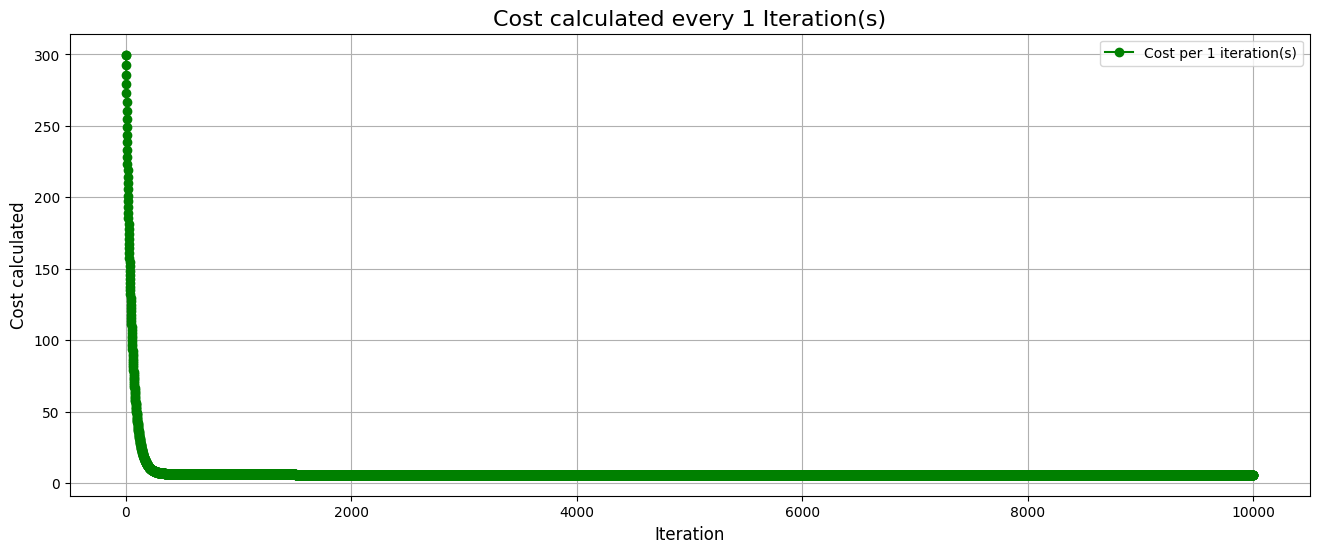

In [43]:
# Graph according k iterations
k = 1
plot_every_k_iterations(k, iterations, cf_history)

##### **Every 100 iterations**

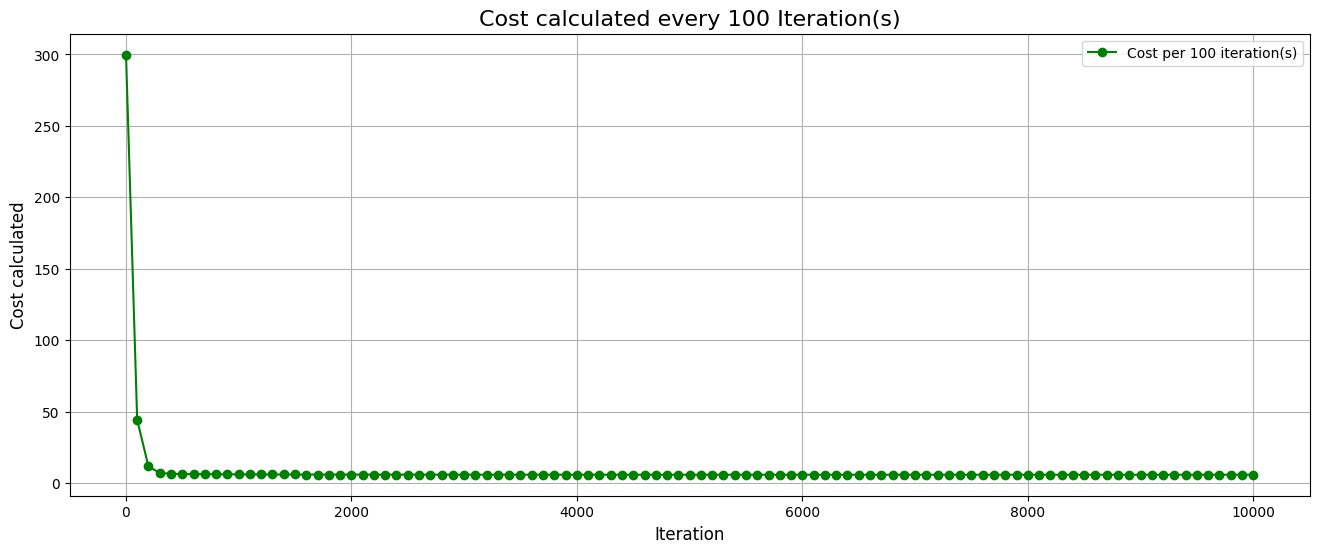

In [44]:
# Graph according k iterations
k = 100
plot_every_k_iterations(k, iterations, cf_history)

##### **Every 500 iterations**

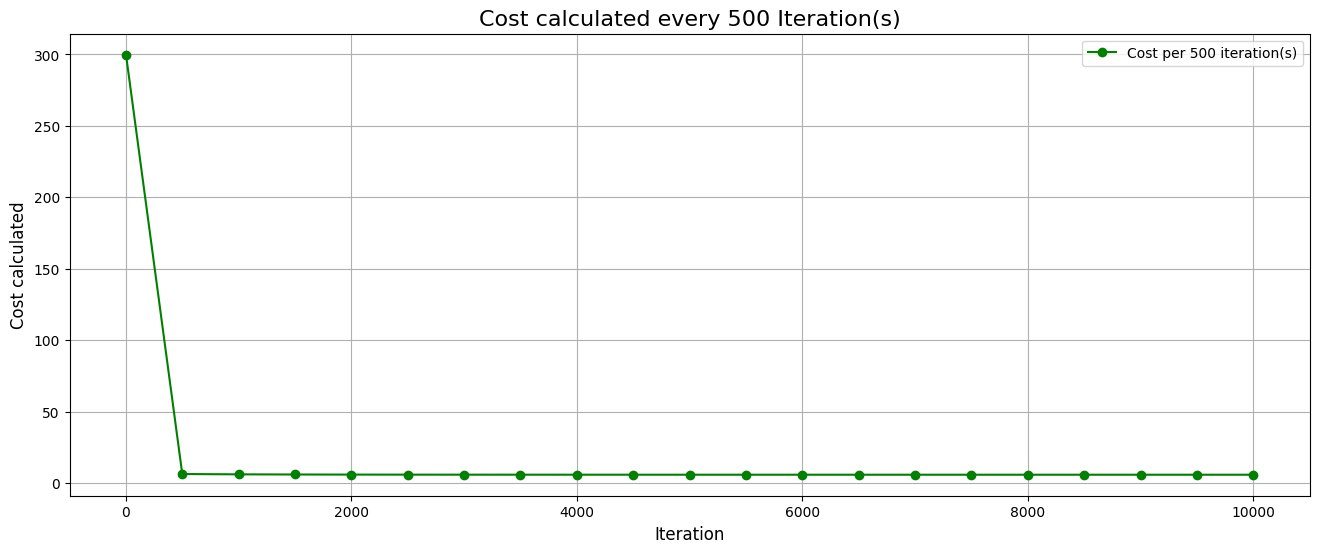

In [45]:
# Graph according k iterations
k = 500
plot_every_k_iterations(k, iterations, cf_history)

##### **Every 1000 iterations**

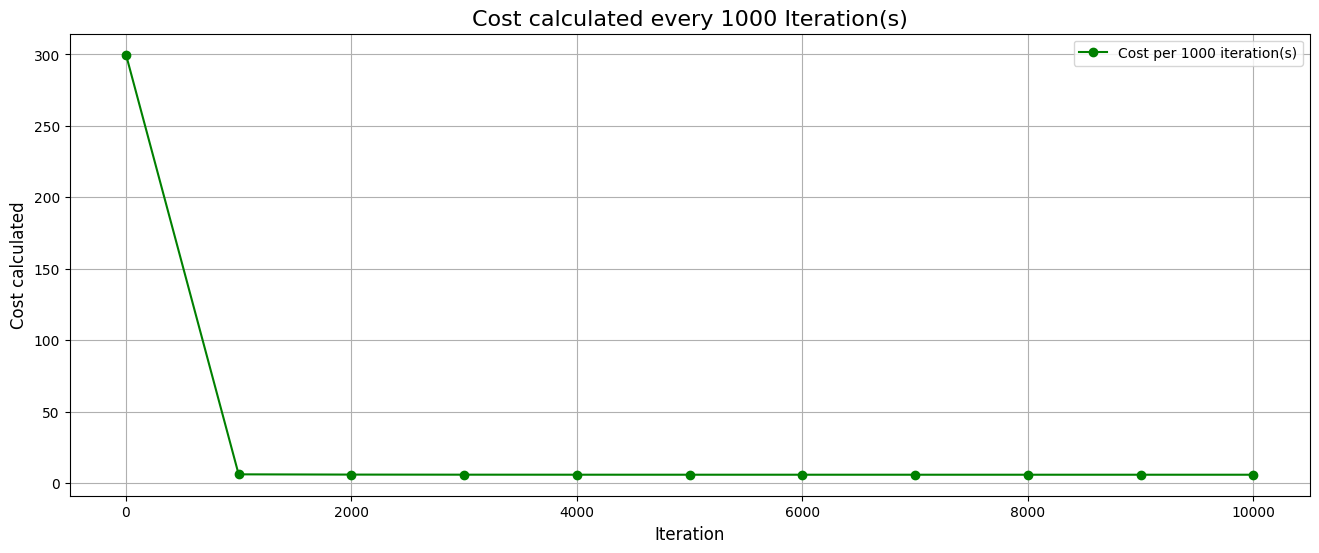

In [46]:
# Graph according k iterations
k = 1000
plot_every_k_iterations(k, iterations, cf_history)

##### **Function found**

We will now use the final parameters from gradient descent to plot the linear fit. 

Recall that we can get the prediction for a single example $f(x^{(i)})= wx^{(i)}+b$. 

$$
\text{fw,b} = 23.502236 + (-1.12003897 \cdot x_1) + (1.39910495 \cdot x_2) + (0.07372277 \cdot x_3) + (-6.05334558 \cdot x_4) + (0.25076846 \cdot x_5) + (2.71040006 \cdot x_6)
$$

#### **Predictions Over Data Test**

$$
\hat{y} = X \cdot w + b
$$

- \( ygorro \): Represents the predicted output.
- \( X \): The matrix of features (or input data).
- \( w \): The vector of coefficients (weights).
- \( b \): The bias (intercept).

To be considered:

1. To calculate the predictions on the test dataset, we can loop through all the test examples and calculate the prediction for each example.

2. Remember that before passing new data through the calculated function, we must normalize them using the mu and sigma values calculed from de training dataset.


In [49]:
# Function to Calculate Error using RMSE
def compute_rmse(predictions, y):
    # Number of examples
    m = len(y)
    
    # Compute MSE
    error_pred = (predictions - y) ** 2
    
    # Calculate RMSE
    rmse = np.sqrt(error_pred.sum() / m)
    
    return rmse

In [50]:
# Normalize New Data
x_test_norm = zscore_normalization_new_data(x_test, mu, sigma)

In [51]:
# Compute Predictions using vectorization
predictions = x_test_norm @ w_cal + b_cal

In [52]:
# Compute Error
rmse = compute_rmse(predictions, y_test)
print(f'RMSE calculated: {rmse:.4f}')

RMSE calculated: 3.4223


**Visual Analysis**

In [90]:
# Compare Observed Values vs Predicted Values
pred_vs_real = pd.DataFrame({
    'y_observed': y_test,
    'y_pred': predictions.round(2)
})

pred_vs_real.head(10)

,y_observed,y_pred
0,13.0,10.13
1,16.0,15.43
2,24.0,25.38
3,28.8,27.55
4,26.0,29.22
5,30.0,25.68
6,15.0,14.19
7,27.0,24.61
8,21.1,28.43
9,31.0,30.17


RMSE calculated: 3.4223


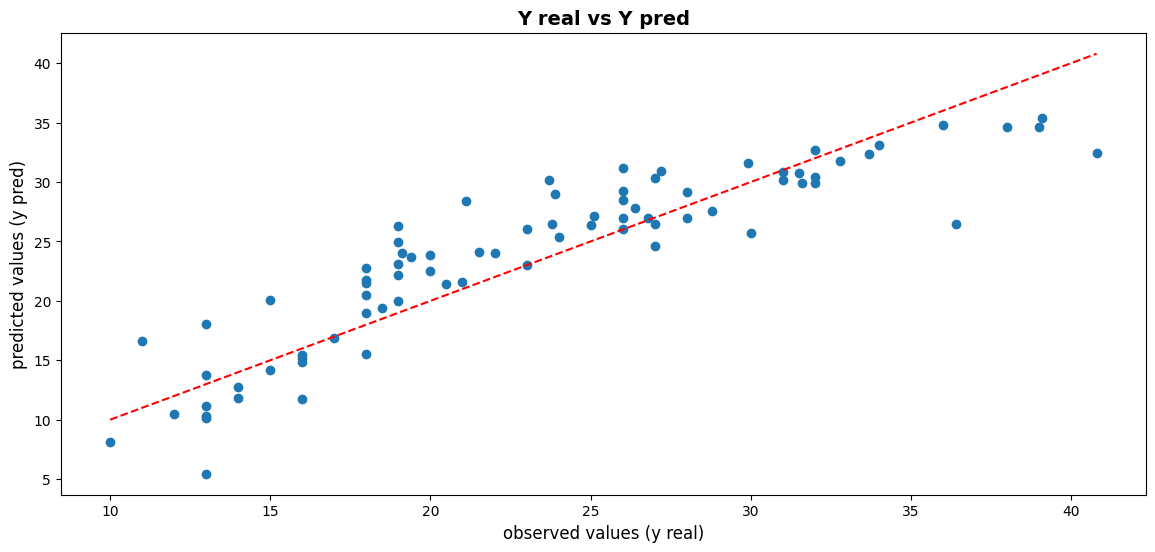

In [94]:
# Graph Observed vs Prd
min_max_real = [min(pred_vs_real['y_observed']), max(pred_vs_real['y_observed'])] # define reference line
print(f'RMSE calculated: {rmse:.4f}')

# Set Plot
plt.figure(figsize=(14, 6))
plt.scatter(pred_vs_real['y_observed'], pred_vs_real['y_pred'])
plt.plot(min_max_real, min_max_real, color='red', linestyle='--')

# Add Labels
plt.xlabel("observed values (y real)", fontsize=12)
plt.ylabel("predicted values (y pred)", fontsize=12)
plt.title('Y real vs Y pred', fontsize=14, fontweight='bold')
plt.show()

#### **Conclusion**

On average, predictions deviate 3.4 units from the actual value. This is about 7% of the range of values of the target variable. In general, the predicted values closely follow the actual values. It is an over-salient fit to the data, however, other configurations and algorithms could be further tested.